In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
 

In [37]:
#This notebook is for analysis on the cBioPortal clinical data
#The goal is to get an idea of how to find related attributes between different studies

#load in packages
import seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import Levenshtein
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams.update({'font.size':20})

##Files without a full header

In [38]:
#find files without header
#load the data
file_list = np.loadtxt("data_clinical_files.txt", dtype=str)

df_list = []
n_attributes = []
i=0
study_data = []
for clinical_file in file_list:
    #load in individual data from files and append to a list
    df = pd.read_table(clinical_file, skiprows=0)
    if (list(df)[0]=='SAMPLE_ID' or list(df)[0]=='PATIENT_ID'):
        print clinical_file

../GSoC-data/brca_metabric/data_clinical_supp_patient.txt
../GSoC-data/brca_metabric/data_clinical_supp_sample.txt
../GSoC-data/brca_metabric/data_clinical_supp_sample_2.txt
../GSoC-data/brca_sanger/2012/data_clinical.txt
../GSoC-data/brca_sanger/2016/data_clinical.txt
../GSoC-data/kich_tcga_pub/2014/data_clinical.txt
../GSoC-data/luad_mskcc_2015/pdx/data_clinical.txt
../GSoC-data/mbl_icgc/2014/data_clinical.txt
../GSoC-data/prad_cpcg_2017/prad_cpcg_2017/data_clinical.txt
../GSoC-data/prad_mskcc/2015/impact/data_clinical.txt
../GSoC-data/prad_mskcc/2015/pan_merged/data_clinical.txt
../GSoC-data/prad_mskcc/2015/pan_met/data_clinical.txt
../GSoC-data/prad_mskcc/2015/pan_primary/data_clinical.txt
../GSoC-data/sarc_mskcc/muralir/4717/data_clinical.txt
../GSoC-data/sarc_mskcc/singers/4610_runb/data_clinical.txt
../GSoC-data/skcm_broad/brafresist/2012/data_clinical.txt


In [145]:
#load the data
file_list = np.loadtxt("data_clinical_files.txt", dtype=str)
study_names = np.asarray([i.split('/', 3)[-2] for i in file_list])

df_list = []
n_attributes = []
i=0
study_data = []
for clinical_file in file_list:
    #if 'sclc_ucologne_2015' in clinical_file:
    #load in individual data from files and append to a list
    df = pd.read_table(clinical_file, skiprows=0)
    if (list(df)[0]!='SAMPLE_ID' and list(df)[0]!='PATIENT_ID'):
        rows_to_skip=df[(df[df.columns[0]]=="SAMPLE_ID") | (df[df.columns[0]]=="PATIENT_ID")].index[0]+1
        df = pd.read_table(clinical_file, skiprows=rows_to_skip)
    df.columns = map(str.upper, df.columns)
    n_attributes.append(df.shape[1])
    df_list.append(df)
    study_name = clinical_file.split('/', 3)[-2]
    col_names = list(df)
    study_data.append((study_name, col_names))
    i+=1

#combine individual dataframes into a single list
all_data = pd.concat(df_list, ignore_index=True)

##Most common attributes present in each study

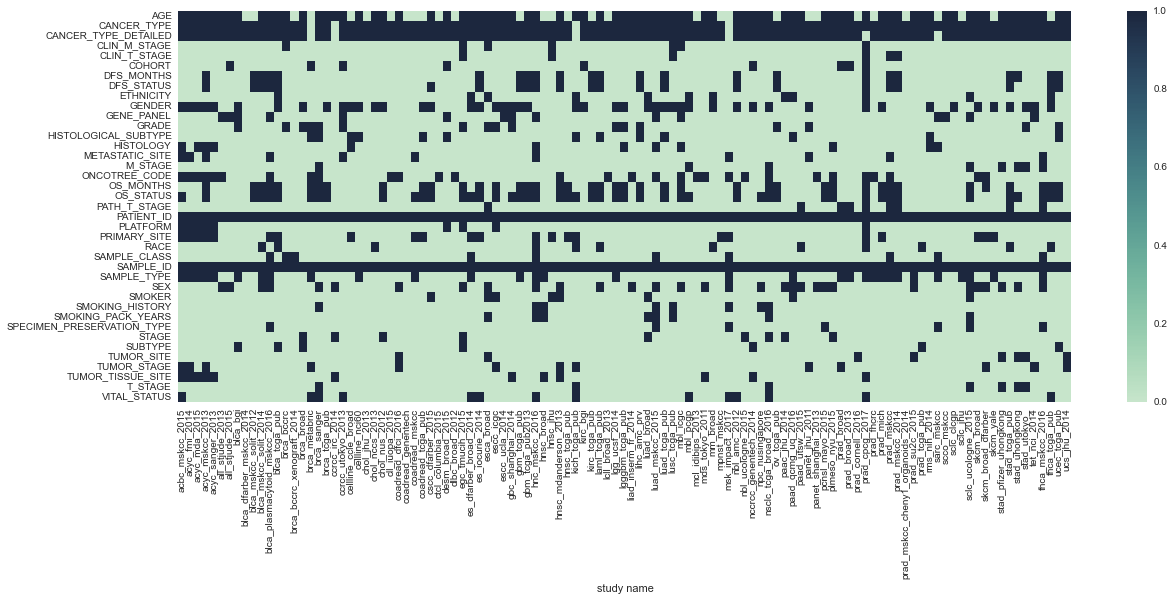

In [270]:
plt.figure(figsize=(20, 7))
cmap=seaborn.cubehelix_palette(rot=-.4, as_cmap=True)
seaborn.heatmap(study_data_combined.T>0, cmap=cmap)

##Clustering on common attributes in studies

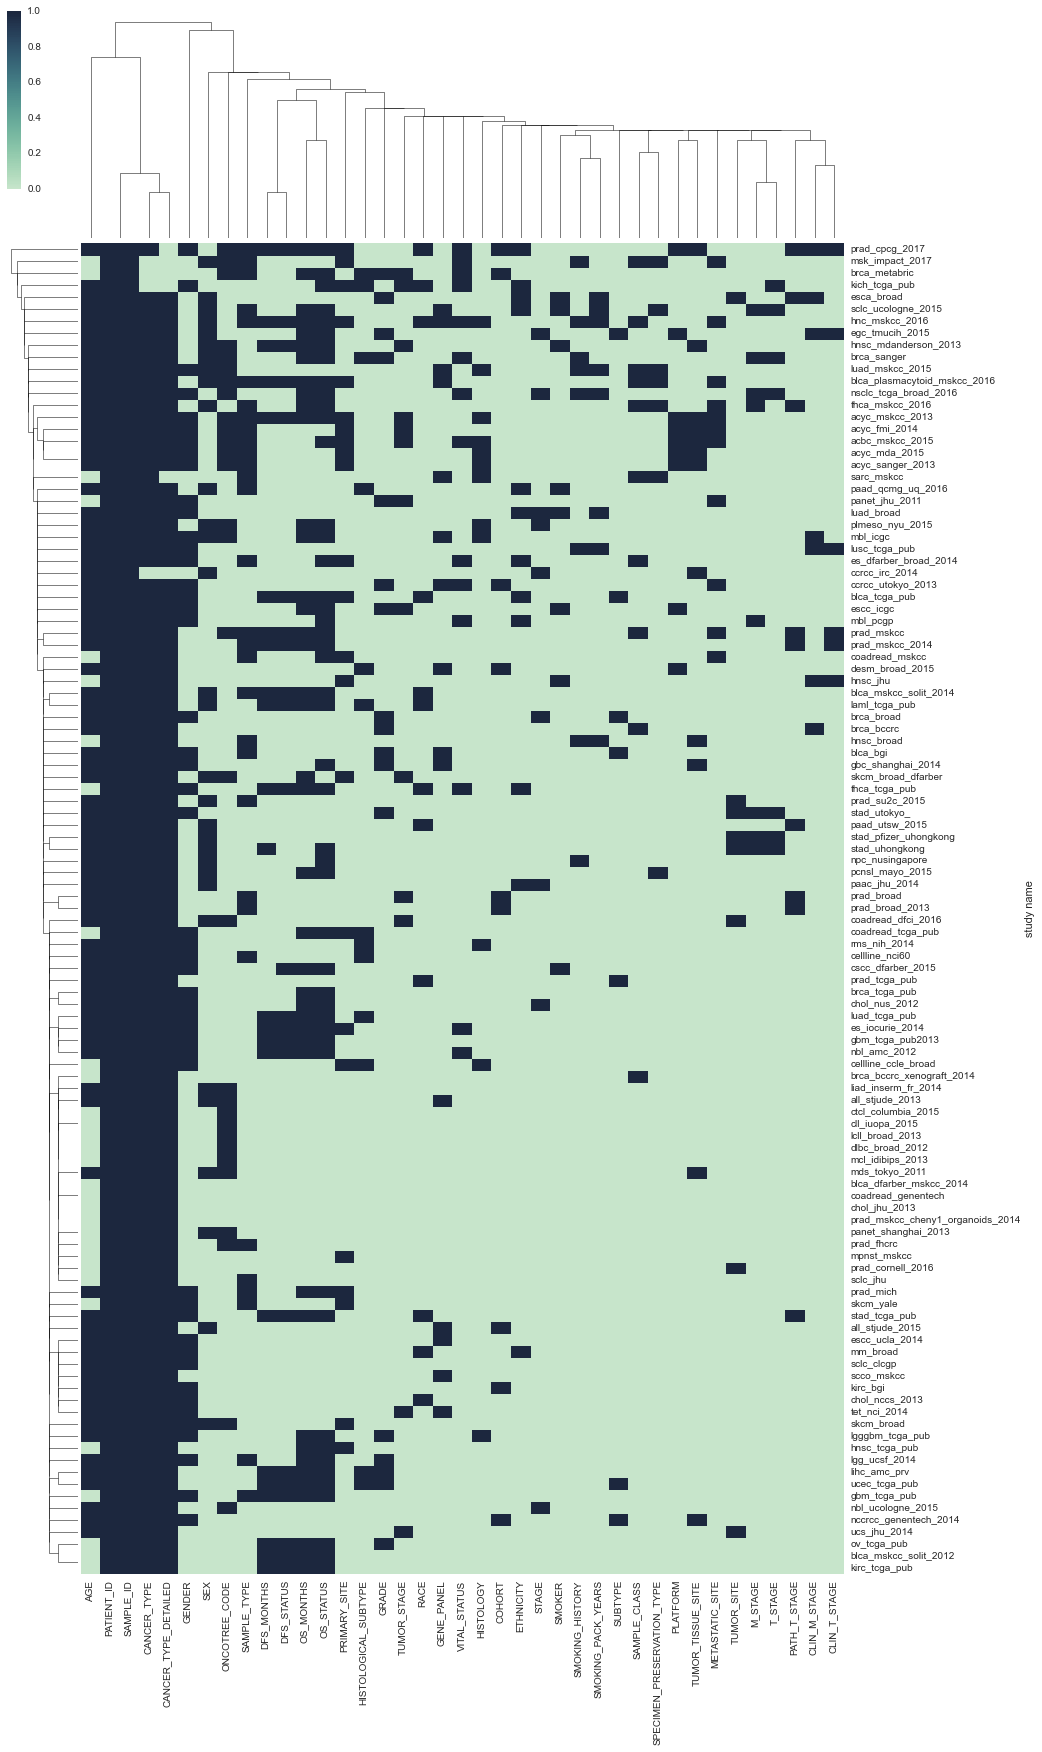

In [269]:
import seaborn
cmap=seaborn.cubehelix_palette(rot=-.4, as_cmap=True)
seaborn.clustermap(study_data_combined>0, method='single', metric = 'euclidean', figsize=(15, 28), cmap=cmap)

##It would be helpful to quantify the similarity between the names of the attributes.  The Levenshtein ratio is one way to quantify the similarity between two strings

In [193]:
#calculate the Levenshtein ratio for all pairs
all_col_names = list(all_data)
total_attributes = len(all_col_names)
lev_dist = np.zeros([total_attributes, total_attributes])
for i in range(total_attributes):
    for j in range(i+1,total_attributes):
        lev_dist[i,j]=Levenshtein.ratio(all_col_names[i].upper(), all_col_names[j].upper())

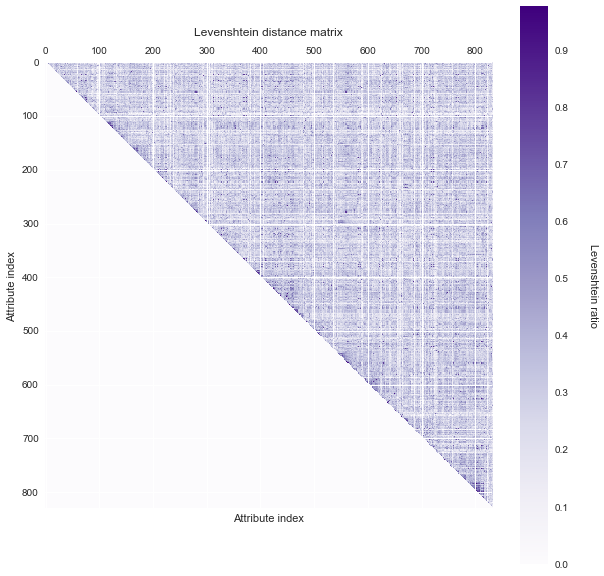

In [194]:
#Let's visualzie the Levenshtein ratio for all possible pairs
plt.rcParams['figure.figsize'] = (10, 10)
plt.matshow(lev_dist, cmap='Purples')
plt.title('Levenshtein distance matrix')
plt.ylabel('Attribute index')
plt.xlabel('Attribute index')
cbar = plt.colorbar()
cbar.set_label("Levenshtein ratio", rotation = 270, labelpad = 30)

##Attributes with a Levenshtein ratio of over 0.90

In [197]:
#let's take a look at the variables that have a Levenshtein ratio of > 0.90
cutoff=0.9
attribute1 = np.where((lev_dist > cutoff))[0]
attribute2 = np.where((lev_dist > cutoff))[1]

#Now let's add an additional filter to make sure the attributes come from different studies
#(this filter is helpful beacuse the same study wouldn't include the same attribute with different names)
for a1, a2 in zip(attribute1,attribute2):
    if sum(all_data[all_col_names[a1]].notnull() & all_data[all_col_names[a2]].notnull()) == 0:
        print all_col_names[a1], all_col_names[a2]

AGE_AT_DIAGNOSIS STAGE_AT_DIAGNOSIS
CDH1_STATUS IDH1_STATUS
DAYS_LAST_FOLLOWUP DAYS_TO_LAST_FOLLOWUP
ERG_STATUS ER_STATUS
HISTOLOGICAL_SUBTYPE HISTOLOGICAL_TYPE
HRAS_MUTATION KRAS_MUTATION
IDH1_STATUS IDH_STATUS
LYMPHNODESEXAMINED LYMPH_NODES_EXAMINED
METASTATICSITE METASTATIC_SITE
METHYLATION CLUSTERS METHYLATION_CLUSTER
MICRORNA_EXPRESSION_CLUSTER MRNA_EXPRESSION_CLUSTER
MYB-NFIB_FISH MYB_NFIB_FISH
NEWTUMOREVENTAFTERINITIALTREATMENT NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT
PAM50 SUBTYPE PAM50_SUBTYPE
PFS_MONTHS PF_MONTHS
PRIMARY_TUMOR_SITE PRIMARY_TUMOR_SIZE
PROSPECTIVECOLLECTION PROSPECTIVE_COLLECTION
PT_STAGE T_STAGE
RADIATION_TREATMENT_ADJUVANT RADIATION_TREATMENT_NEOADJUVANT
TNMSTAGE TNM_STAGE
TUMORGRADE TUMOR_GRADE
TUMORSTAGE TUMOR_STAGE


##Attributes with a Levenshtein ratio of over 0.80

In [199]:
#let's take a look at the variables that have a Levenshtein ratio of > 0.80
cutoff=0.8
attribute1 = np.where((lev_dist > cutoff))[0]
attribute2 = np.where((lev_dist > cutoff))[1]

#Now let's add an additional filter to make sure the attributes come from different studies
#(this filer is helpful beacuse the same study wouldn't include the same attribute with different names)
for a1, a2 in zip(attribute1,attribute2):
    if sum(all_data[all_col_names[a1]].notnull() & all_data[all_col_names[a2]].notnull()) == 0:
        print all_col_names[a1], all_col_names[a2]

AGE_AT_DIAGNOSIS STAGE_AT_DIAGNOSIS
AGE_AT_LAST_FOLLOWUP DAYS_TO_LAST_FOLLOWUP
AGE_AT_LAST_FOLLOWUP TIME_TO_LAST_FOLLOWUP
ARID1A_MUTATION IDH1_MUTATION
ARM_SCNA_CLUSTER SCNA_CLUSTER
AR_SCORE ERK_SCORE
ATRX_STATUS STR_STATUS
BCR_STATUS BRAF_STATUS
BCR_STATUS ER_STATUS
BCR_STATUS PR_STATUS
BIOPSY_GLEASON_SCORE_1 GLEASON_SCORE_1
BIOPSY_GLEASON_SCORE_2 GLEASON_SCORE_2
BRAF_MUTATION KRAS_MUTATION
BRAF_MUTATION RHOA_MUTATION
BRCA1_GERMLINE_MUT BRCA_GERMLINE_MUTATIONS
BRCA1_MUTATION KRAS_MUTATION
BRCA1_MUTATION RHOA_MUTATION
BRCA2_GERMLINE_MUT BRCA_GERMLINE_MUTATIONS
BRCA2_MUTATION KRAS_MUTATION
BRCA2_MUTATION RHOA_MUTATION
CDH1_STATUS IDH1_STATUS
CDH1_STATUS IDH_STATUS
CDH1_STATUS LDH_STATUS
CLINICAL_STAGE CLINICAL_STATUS
CNA_CLUSTER_K4 SCNA_CLUSTER
COMMENTS SO_COMMENTS
DAYS_LAST_FOLLOWUP DAYS_TO_LAST_FOLLOWUP
DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS YEAR_OF_INITIAL_PATHOLOGIC_DIAGNOSIS
DAYS_TO_LAST_FOLLOWUP TIME_TO_LAST_FOLLOWUP
DFS_MONTHS PFS_MONTHS
DOUBLING_TIME DOUBLING_TIME_DAYS
EBV_STATUS 

##Determine the number of common attributes between pairs of studies

In [290]:
study_names = list(study_data_combined.T)
n_studies = len(study_names)
n_common_attributes = pd.DataFrame(index=study_names, columns=study_names)
n_common_attributes = n_common_attributes.fillna(0.0)
n_attribute_dist = []
#n_common_attributes = np.zeros([n_studies, n_studies])

for i in range(n_studies):
    for j in range(n_studies):
        #n_common_attributes[i, j] = sum((study_data_combined.T[study_names[i]]>0) & (study_data_combined.T[study_names[j]]>0))
        n_attributes = sum((study_data_combined.T[study_names[i]]>0) & (study_data_combined.T[study_names[j]]>0))
        n_common_attributes.ix[i, study_names[j]] = n_attributes
        if j>i:
            n_attribute_dist.append(n_attributes)

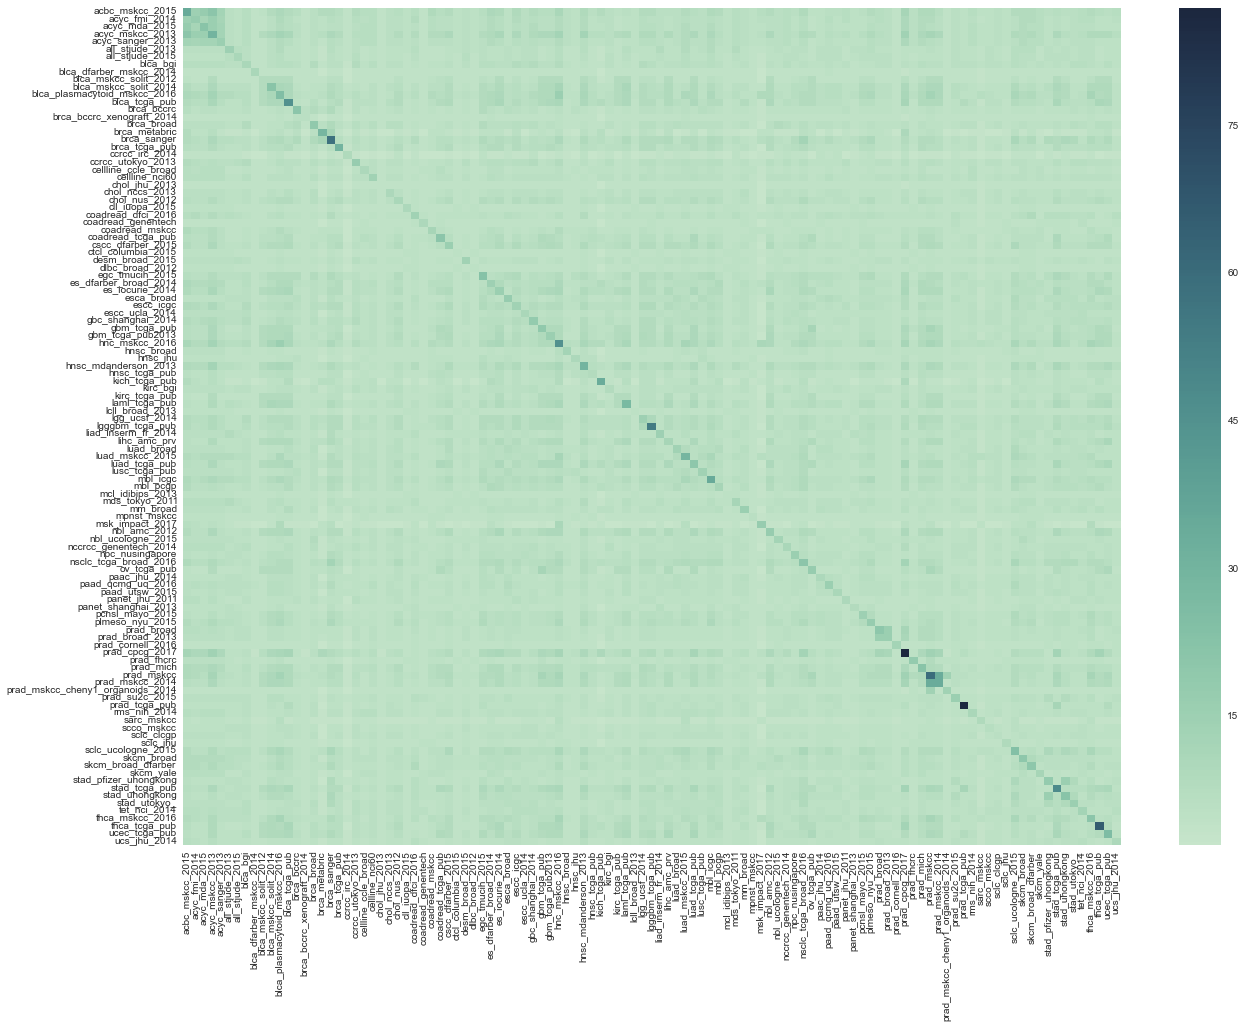

In [286]:
fig, ax = plt.subplots(figsize=(21,15))
cmap=seaborn.cubehelix_palette(rot=-.4, as_cmap=True)
seaborn.heatmap(n_common_attributes, cmap=cmap)

##Distribution of attributes in common for each pair of studies

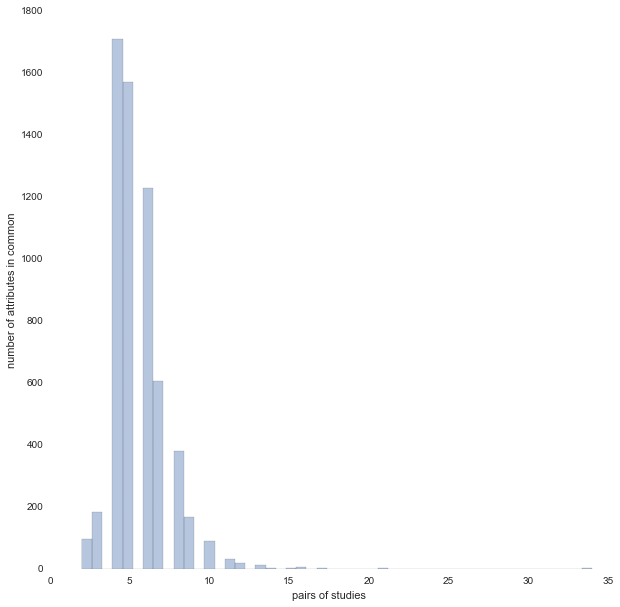

In [294]:
ax=seaborn.distplot(n_attribute_dist, kde=False)
ax.set(xlabel='pairs of studies', ylabel='number of attributes in common')
plt.show()
